In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


## Importing Libraries and Data Reading

In [1]:
# function to find the false positive rate, accuracy and confusion matrix
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score

def eval(y_pred,y_test):
    cm=confusion_matrix(y_test,y_pred)
    TP = cm[1, 1]
    FN = cm[1, 0]
    
    FNR = FN/ (FN + TP)
    acc=accuracy_score(y_test,y_pred)
    print(cm)
    print('False Negative Rate', FNR)
    print('Accuracy', acc)


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
X=pd.read_csv('loan_prediction.csv')

In [4]:
X.columns

Index(['Unnamed: 0', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
X.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
X.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Exploratory Data Analysis

<Axes: xlabel='Loan_Status', ylabel='count'>

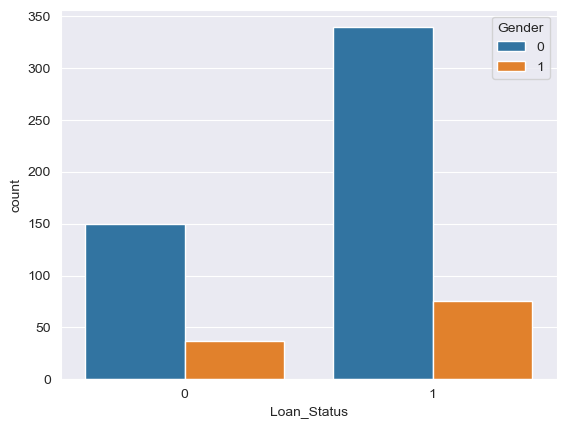

In [7]:
sns.set_style('darkgrid')
sns.countplot(data=X, x='Loan_Status', hue='Gender')

In [8]:
df=X.copy()


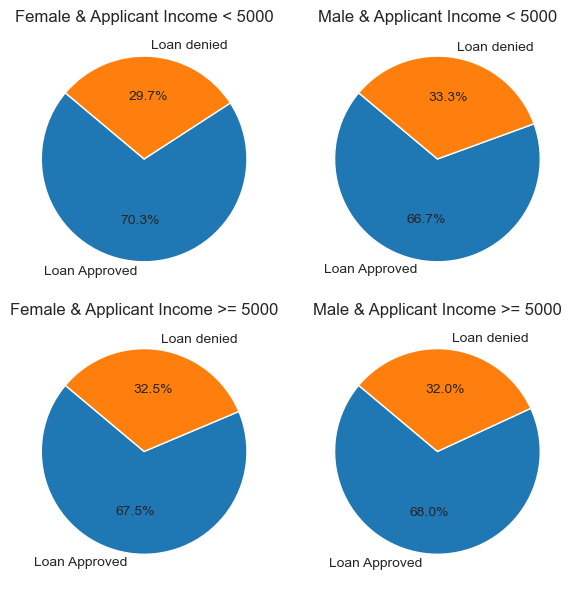

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(6,6))

labels = ['Loan Approved','Loan denied']
start_angle = 140

# Plot for Female and Income < 5000
axs[0, 0].pie(df[(df['Gender'] == 0) & (df['ApplicantIncome'] < 5000)]['Loan_Status'].value_counts(), labels=labels, autopct='%1.1f%%', startangle=start_angle)
axs[0, 0].set_title('Female & Applicant Income < 5000')

# Plot for Male and Income < 5000
axs[0, 1].pie(df[(df['Gender'] == 1) & (df['ApplicantIncome'] < 5000)]['Loan_Status'].value_counts(), labels=labels, autopct='%1.1f%%', startangle=start_angle)
axs[0, 1].set_title('Male & Applicant Income < 5000')

# Plot for Female and Income >= 5000
axs[1, 0].pie(df[(df['Gender'] == 0) & (df['ApplicantIncome'] >= 5000)]['Loan_Status'].value_counts(), labels=labels, autopct='%1.1f%%', startangle=start_angle)
axs[1, 0].set_title('Female & Applicant Income >= 5000')

# Plot for Male and Income >= 5000
axs[1, 1].pie(df[(df['Gender'] == 1) & (df['ApplicantIncome'] >= 5000)]['Loan_Status'].value_counts(), labels=labels, autopct='%1.1f%%', startangle=start_angle)
axs[1, 1].set_title('Male & Applicant Income >= 5000')

plt.tight_layout()
plt.show()

<Axes: xlabel='Gender', ylabel='count'>

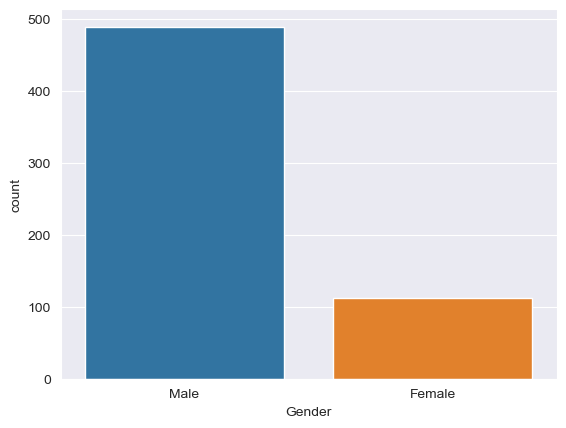

In [20]:
import seaborn as sns
temp=df.copy()
temp['Gender']=temp.apply(lambda x: 'Female' if x['Gender']==1 else 'Male',axis=1)
sns.set_style('darkgrid')
sns.countplot(x='Gender', data=temp)

<Axes: xlabel='Loan_Status', ylabel='count'>

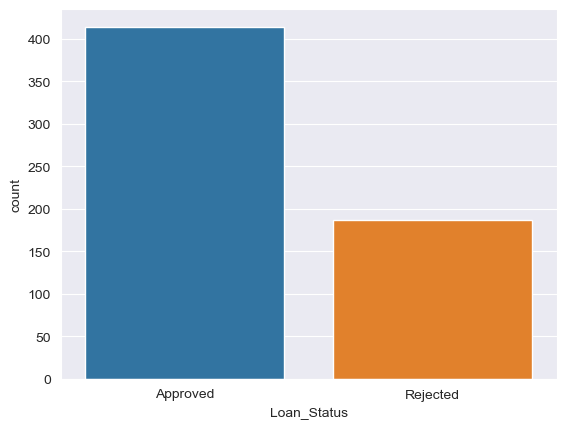

In [22]:
import seaborn as sns
temp['Loan_Status']=temp['Loan_Status'].map({1:'Approved',0:'Rejected'})
sns.set_style('darkgrid')
sns.countplot(x='Loan_Status', data=temp)

In [10]:
y=X['Loan_Status']

In [11]:
X.drop('Loan_Status',axis=1,inplace=True)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    int64  
 1   Married            601 non-null    int64  
 2   Dependents         601 non-null    int64  
 3   Education          601 non-null    int64  
 4   Self_Employed      601 non-null    int64  
 5   ApplicantIncome    601 non-null    int64  
 6   CoapplicantIncome  601 non-null    float64
 7   LoanAmount         601 non-null    float64
 8   Loan_Amount_Term   601 non-null    float64
 9   Credit_History     601 non-null    float64
 10  Property_Area      601 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 51.8 KB


# Modelling

In [13]:
#splitting into train test with 20% test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [14]:
#function to find statiscal parity and equal opportunity

def stat_parity(preds, sens):

    #counter variable to count when sens is 1
    count_sensitive=0
    #counter variable to count when sens is 0
    count_not_sensitive=0
    #counter variable to count when sens is 1 and preds is also 1
    pred_1_sensitive=0
    #counter variable to count when sens is 0 and preds is 1
    pred_1_non_sensitive=0
    
    
    for i in range(len(preds)): #iterate through preds and sens
        if sens[i]==1:
            count_sensitive+=1 # if sens is 1 i.e it is a sensitive class increase counter
            if preds[i]==1:
                 pred_1_sensitive+=1 # if pred is 1 when sens is 1 increase counter
        elif sens[i]==0:
            count_not_sensitive+=1 # if sens is 0 i.e it is not a sensitive class increase counter
            if preds[i]==1:
                pred_1_non_sensitive+=1 # if pred is 1 when sens is 0 increase counter
    
    #stat_parity is always between 0 and 1. so I have checked if the denominator is 0. if it is 0 then stats parity for that factor should be lowest i.e 0
    if (count_sensitive==0):
        sens_ans=0 # if there is no sensitive class in data set sensitive class output to 0
    else:
        sens_ans=(pred_1_sensitive/count_sensitive) # else output for sensitive class P(ypred=1/A=1)
        
    if(count_not_sensitive)==0:
        not_sens_ans=0 # if there is no non sensitive class in data set non sensitive class output to 0
    else:
        not_sens_ans=(pred_1_non_sensitive/count_not_sensitive)# else output for non sensitive class P(ypred=1/A=0)
    
    return sens_ans-not_sens_ans # return difference


def eq_oppo(preds, sens, labels):

    #counter variable to count when sens is 1 and ytrue is 1
    count_sensitive=0
    #counter variable to count when sens is 0 and ytrue is 1
    count_not_sensitive=0
    #counter variable to count when sens is 1 and preds is also 1 and ytrue is also 1
    pred_1_sensitive=0
    #counter variable to count when sens is 0 and preds is also 1 and ytrue is also 1
    pred_1_non_sensitive=0
    
    for i in range(len(preds)): #iterate through preds and sens and labels
        if sens[i]==1 and labels[i]==1: 
            count_sensitive+=1 # if both sens=1 and ytrue=1 increase sensitive class counter
            if preds[i]==1:
                 pred_1_sensitive+=1 # if all three are 1 increase counter
        elif sens[i]==0 and labels[i]==1:
            count_not_sensitive+=1 # if class is not sensitive but ytrue=1 increase counter
            if preds[i]==1:
                pred_1_non_sensitive+=1 #if pred is 1, class!=sensitive and ytrue=1 increase counter

    #equal opportunity between 0 and 1. so I have checked if the denominator is 0. if it is 0 then equal opportunity for that factor should be lowest i.e 0
    if (count_sensitive==0):
        sens_ans=0 # if there is no sensitive class for which ytrue=1 in data set sensitive class output to 0
    else:
        sens_ans=(pred_1_sensitive/count_sensitive)# else output for sensitive class P(ypred=1/A=1, label=1)
        
    if(count_not_sensitive)==0:
        not_sens_ans=0 # if there is no non sensitive class for which ytrue=1 in data set non sensitive class output to 0
    else:
        not_sens_ans=(pred_1_non_sensitive/count_not_sensitive)# else output for non sensitive class P(ypred=1/A=0, label=1)
    return sens_ans-not_sens_ans #return difference

## 1. LightGBM

In [15]:
# building lightgbm model with binary classification
import lightgbm as lgb

params = {
    'objective': 'binary',
}

In [16]:
# building train and test dataset for lightgbm and training the model on the train dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Number of positive: 327, number of negative: 153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.681250 -> initscore=0.759522
[LightGBM] [Info] Start training from score 0.759522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [17]:
#predicting on test with the best iteration model and converting the probabilities to 1 and 0
y_pred = list(model.predict(X_test, num_iteration=model.best_iteration))
y_pred=[1 if x>=0.5 else 0 for x in y_pred ]

In [18]:
#statistical parity
stat_parity(y_pred, np.array(X_test['Gender']))

0.0019047619047618536

In [19]:
#equal opportunity
eq_oppo(y_pred, np.array(X_test['Gender']), np.array(y_test))

-0.022222222222222143

In [20]:
# using the eval function to find the other metrics defined above
eval(y_pred,y_test)

[[19 15]
 [10 77]]
False Negative Rate 0.11494252873563218
Accuracy 0.7933884297520661


## 2. SMOTE + LightGBM

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
#using smote to balance the data by oversampling
smote = SMOTE(random_state=0)

In [23]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [24]:
y_train_smote.value_counts()

Loan_Status
1    327
0    327
Name: count, dtype: int64

In [25]:
smote_df=X_train_smote.copy()

In [26]:
smote_df['Loan_Status']=y_train_smote


In [27]:
# building train and test dataset for lightgbm and training the model on the train dataset
lgb_train = lgb.Dataset(X_train_smote, y_train_smote)
lgb_test = lgb.Dataset(X_test, y_test)

model_sm= lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Number of positive: 327, number of negative: 327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 654, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [28]:
#predicting on test with the best iteration model and converting the probabilities to 1 and 0
y_pred_sm = list(model_sm.predict(X_test, num_iteration=model_sm.best_iteration))
y_pred_sm=[1 if x>=0.5 else 0 for x in y_pred_sm ]

In [29]:
#statistical parity
stat_parity(y_pred_sm, np.array(X_test['Gender']))

0.024285714285714355

In [30]:
#equal opportunity
eq_oppo(y_pred_sm, np.array(X_test['Gender']), np.array(y_test))

0.07500000000000007

In [31]:
# using the eval function to find the other metrics defined above
eval(y_pred_sm,y_test)

[[20 14]
 [17 70]]
False Negative Rate 0.19540229885057472
Accuracy 0.743801652892562


## 3. BorderlineSMOTE + LightGBM

In [32]:
#another oversampling technique; borderline smote balances the data
from imblearn.over_sampling import BorderlineSMOTE
bs = BorderlineSMOTE(random_state=0)

X_train_bs, y_train_bs = bs.fit_resample(X_train, y_train)

In [33]:
y_train_bs.value_counts()

Loan_Status
1    327
0    327
Name: count, dtype: int64

In [34]:
# building train and test dataset for lightgbm and training the model on the train dataset
lgb_train = lgb.Dataset(X_train_bs, y_train_bs)
lgb_test = lgb.Dataset(X_test, y_test)

model_bs= lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Number of positive: 327, number of negative: 327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 654, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [35]:
#predicting on test with the best iteration model and converting the probabilities to 1 and 0
y_pred_bs = list(model_bs.predict(X_test, num_iteration=model_bs.best_iteration))
y_pred_bs=[1 if x>=0.5 else 0 for x in y_pred_bs ]

In [36]:
#statistical parity
stat_parity(y_pred_bs, np.array(X_test['Gender']))

-0.0357142857142857

In [37]:
#equal opportunity
eq_oppo(y_pred_bs, np.array(X_test['Gender']), np.array(y_test))

-0.008333333333333304

In [38]:
# using the eval function to find the other metrics defined above
eval(y_pred_bs,y_test)

[[20 14]
 [11 76]]
False Negative Rate 0.12643678160919541
Accuracy 0.7933884297520661


## 4. Reweighing + LightGBM

In [ ]:
!pip install 'aif360[AdversarialDebiasing]'

In [39]:
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [40]:
#Creating a copy of the original dataset with y values appended to it, to calculate the weights
X_train_y=X_train.copy()
X_test_y=X_test.copy()
X_train_y['y']=y_train
X_test_y['y']=y_test

In [41]:
#setting the protected variable as gender and building a binary dataset from the above copy dataset
attributes_params = dict(
    protected_attribute_names=['Gender'],
    label_names=['y']
)
X_train_binary = BinaryLabelDataset(df=X_train_y, **attributes_params)
X_test_binary = BinaryLabelDataset(df=X_test_y, **attributes_params)


In [42]:
#calculating the weights by mentioning priviledged and non-priviledged groups
RW = Reweighing(unprivileged_groups=[{'Gender':1}],
               privileged_groups=[{'Gender':0}])


In [43]:
X_train_RW=RW.fit_transform(X_train_binary)
y_test=X_test_y['y']
X_test_y.drop('y',axis=1,inplace=True)
y_train=X_train_y['y']
X_train_y.drop('y',axis=1,inplace=True)


In [44]:
#assigning weights to the lgb dataset and building the model
weights = X_train_RW.instance_weights

lgb_train = lgb.Dataset(X_train_y, y_train,weight=weights)
lgb_test = lgb.Dataset(X_test_y, y_test)

model_aif= lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Number of positive: 327, number of negative: 153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.681250 -> initscore=0.759522
[LightGBM] [Info] Start training from score 0.759522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [45]:
#predicting on test with the best iteration model and converting the probabilities to 1 and 0
y_pred_aif = list(model_aif.predict(X_test, num_iteration=model_aif.best_iteration))
y_pred_aif=[1 if x>=0.5 else 0 for x in y_pred_aif ]

In [46]:
#statistical parity
stat_parity(y_pred_aif, np.array(X_test['Gender']))

-0.05809523809523809

In [47]:
#equal opportunity
eq_oppo(y_pred_aif, np.array(X_test['Gender']), np.array(y_test))

-0.09166666666666667

In [48]:
# using the eval function to find the other metrics defined above
eval(y_pred_aif,y_test)

[[18 16]
 [ 5 82]]
False Negative Rate 0.05747126436781609
Accuracy 0.8264462809917356


## 5. Penalized Matrix XGBoost

In [70]:
!pip install xgboost

In [122]:
#defining the matrix with penalty values
#this matrix only for female where 1.2 and 1.45 are the penalties that will be
#applied to the model if the model makes incorrect predictions
#it will multiply the penalty with the loss of the model
penalty_matrix = np.array([[1, 1.2], [1.45, 1]]) 
penalty_matrix=pd.DataFrame(penalty_matrix)

In [123]:
#the below code is the code of the xgboost model with the objective function and predict function
#the model with multipy the penalty with the grad and hess loss of the model
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import argparse

np.random.seed(1994)


kRows = X_train.shape[0]
kCols = len(X_train.columns)
kClasses = 2 # number of classes
kRounds =  100      # number of boosting rounds.


m = xgb.DMatrix(np.array(X_train), np.array(y_train))

gender_list=np.array(X_train['Gender'])
def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)


def softprob_obj(predt: np.ndarray, data: xgb.DMatrix):
    '''Loss function.  Computing the gradient and approximated hessian (diagonal).
    Reimplements the `multi:softprob` inside XGBoost.
    '''
    labels = data.get_label()
    if data.get_weight().size == 0:
     
        weights = np.ones((kRows, 1), dtype=float)
    else:
        weights = data.get_weight()

    assert predt.shape == (kRows, kClasses)
    key_list=[0,1]
    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float)

    eps = 1e-6

   
    for r in range(predt.shape[0]):
        gender=gender_list[r]
        target = labels[r]
        p = softmax(predt[r, :])
        tar=key_list[int(target)]
      
        max_pred=np.argmax(p)
        pred=key_list[max_pred]
     
        for c in range(predt.shape[1]):
            assert target >= 0 or target <= kClasses
            g = p[c] - 1.0 if c == target else p[c]

            if gender==1:
                g = g * (penalty_matrix.loc[tar][pred])
            else:
                g=g*1
              
            if gender==1:
                  h = max((2.0 * p[c] * (1.0 - p[c]) * penalty_matrix.loc[tar][pred]).item(), eps)
            else:
                  h = max((2.0 * p[c] * (1.0 - p[c]) * 1).item(), eps)
            grad[r, c] = g
            hess[r, c] = h

    grad = grad.reshape((kRows * kClasses, 1))
    hess = hess.reshape((kRows * kClasses, 1))
    return grad, hess


def predict(booster: xgb.Booster, X):

    predt = booster.predict(X, output_margin=True)
    out = np.zeros(kRows)
    for r in range(predt.shape[0]):

        i = np.argmax(predt[r])
        out[r] = i
    return out


In [124]:
#model building
#100 rounds
#learning rate of 0.2
booster_custom_1= xgb.train({'num_class': kClasses,'eval_metric': 'mlogloss','eta':0.2},
                               m,
                               num_boost_round=kRounds,
                               
                               obj=softprob_obj,
                               evals=[(m, 'train')])

[0]	train-mlogloss:0.60783
[1]	train-mlogloss:0.54920
[2]	train-mlogloss:0.49446
[3]	train-mlogloss:0.45407
[4]	train-mlogloss:0.43022
[5]	train-mlogloss:0.40622
[6]	train-mlogloss:0.38039
[7]	train-mlogloss:0.36278
[8]	train-mlogloss:0.34734
[9]	train-mlogloss:0.33786
[10]	train-mlogloss:0.32665
[11]	train-mlogloss:0.30825
[12]	train-mlogloss:0.29972
[13]	train-mlogloss:0.28808
[14]	train-mlogloss:0.28084
[15]	train-mlogloss:0.27414
[16]	train-mlogloss:0.26356
[17]	train-mlogloss:0.25882
[18]	train-mlogloss:0.25323
[19]	train-mlogloss:0.24774
[20]	train-mlogloss:0.24505
[21]	train-mlogloss:0.24100
[22]	train-mlogloss:0.23610
[23]	train-mlogloss:0.23190
[24]	train-mlogloss:0.22886
[25]	train-mlogloss:0.22303
[26]	train-mlogloss:0.21727
[27]	train-mlogloss:0.20802
[28]	train-mlogloss:0.20499
[29]	train-mlogloss:0.20328
[30]	train-mlogloss:0.20184
[31]	train-mlogloss:0.19621
[32]	train-mlogloss:0.19329
[33]	train-mlogloss:0.19103
[34]	train-mlogloss:0.18726
[35]	train-mlogloss:0.18542
[3

In [125]:

#predicting the values for test
#printing statiscal parity, equal opportunity and other metrics

predtr_custom=booster_custom_1.predict( xgb.DMatrix(X_train))
predt=booster_custom_1.predict( xgb.DMatrix(X_test))


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predt))


print(stat_parity(predt, np.array(X_test['Gender'])))
print(eq_oppo(predt, np.array(X_test['Gender']), np.array(y_test)))

0.743801652892562
0.0019047619047618536
0.019444444444444486


In [126]:
eval(predt,y_test)

[[16 18]
 [13 74]]
False Negative Rate 0.14942528735632185
Accuracy 0.743801652892562


## 6. SMOTE + Penalized Matrix XGBoost


In [118]:
#the below code is the code of the xgboost model with the objective function and predict function
#the model with multipy the penalty with the grad and hess loss of the model
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import argparse

np.random.seed(1994)

kRows = X_train_bs.shape[0]
kCols = len(X_train_bs.columns)
kClasses = 2 # number of classes
kRounds =  100     # number of boosting rounds.


m = xgb.DMatrix(np.array(X_train_bs), np.array(y_train_bs))

gender_list=np.array(X_train_bs['Gender'])
def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)


def softprob_obj(predt: np.ndarray, data: xgb.DMatrix):
    '''Loss function.  Computing the gradient and approximated hessian (diagonal).
    Reimplements the `multi:softprob` inside XGBoost.
    '''
    labels = data.get_label()
    if data.get_weight().size == 0:

        weights = np.ones((kRows, 1), dtype=float)
    else:
        weights = data.get_weight()

    assert predt.shape == (kRows, kClasses)
    key_list=[0,1]
    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float)

    eps = 1e-6


    for r in range(predt.shape[0]):
        gender=gender_list[r]
        target = labels[r]
        p = softmax(predt[r, :])
        tar=key_list[int(target)]
      
        max_pred=np.argmax(p)
        pred=key_list[max_pred]
     
        for c in range(predt.shape[1]):
            assert target >= 0 or target <= kClasses
            g = p[c] - 1.0 if c == target else p[c]

            if gender==1:
                g = g * (penalty_matrix.loc[tar][pred])
            else:
                g=g*1
              
            if gender==1:
                  h = max((2.0 * p[c] * (1.0 - p[c]) * penalty_matrix.loc[tar][pred]).item(), eps)
            else:
               h = max((2.0 * p[c] * (1.0 - p[c]) * 1).item(), eps)
            grad[r, c] = g
            hess[r, c] = h
      
    grad = grad.reshape((kRows * kClasses, 1))
    hess = hess.reshape((kRows * kClasses, 1))
    return grad, hess


def predict(booster: xgb.Booster, X):
    '''A customized prediction function that converts raw prediction to
    target class.
    '''

    predt = booster.predict(X, output_margin=True)
    out = np.zeros(kRows)
    for r in range(predt.shape[0]):

        i = np.argmax(predt[r])
        out[r] = i
    return out


In [119]:
#model building
#100 rounds
#learning rate of 0.2
booster_custom_bs= xgb.train({'num_class': kClasses,'eval_metric': 'mlogloss','eta':0.2},
                               m,
                               num_boost_round=kRounds,
                               
                               obj=softprob_obj,
                               evals=[(m, 'train')])

[0]	train-mlogloss:0.59398
[1]	train-mlogloss:0.52340
[2]	train-mlogloss:0.47121
[3]	train-mlogloss:0.42843
[4]	train-mlogloss:0.39334
[5]	train-mlogloss:0.36502
[6]	train-mlogloss:0.34420
[7]	train-mlogloss:0.32193
[8]	train-mlogloss:0.30477
[9]	train-mlogloss:0.28409
[10]	train-mlogloss:0.27098
[11]	train-mlogloss:0.25656
[12]	train-mlogloss:0.24862
[13]	train-mlogloss:0.23860
[14]	train-mlogloss:0.23144
[15]	train-mlogloss:0.22171
[16]	train-mlogloss:0.21433
[17]	train-mlogloss:0.20820
[18]	train-mlogloss:0.20189
[19]	train-mlogloss:0.19658
[20]	train-mlogloss:0.18956
[21]	train-mlogloss:0.18271
[22]	train-mlogloss:0.17749
[23]	train-mlogloss:0.17431
[24]	train-mlogloss:0.17229
[25]	train-mlogloss:0.17006
[26]	train-mlogloss:0.16726
[27]	train-mlogloss:0.16536
[28]	train-mlogloss:0.15903
[29]	train-mlogloss:0.15751
[30]	train-mlogloss:0.15273
[31]	train-mlogloss:0.15023
[32]	train-mlogloss:0.14597
[33]	train-mlogloss:0.14349
[34]	train-mlogloss:0.13995
[35]	train-mlogloss:0.13727
[3

In [120]:
#predicting the values for test
#printing statiscal parity, equal opportunity and other metrics
predt=booster_custom_bs.predict( xgb.DMatrix(X_test))


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predt))


print(stat_parity(predt, np.array(X_test['Gender'])))
print(eq_oppo(predt, np.array(X_test['Gender']), np.array(y_test)))

0.743801652892562
-0.033333333333333326
0.07500000000000007


In [121]:
eval(predt,y_test)

[[20 14]
 [17 70]]
False Negative Rate 0.19540229885057472
Accuracy 0.743801652892562


## 7. Reweighing + Penalized Xgboost

In [109]:
#Creating a copy of the original dataset with y values appended to it, to calculate the weights
X_train_y=X_train.copy()
X_test_y=X_test.copy()
X_train_y['y']=y_train
X_test_y['y']=y_test

In [110]:
#setting the protected variable as gender and building a binary dataset from the above copy dataset
attributes_params = dict(
    protected_attribute_names=['Gender'],
    label_names=['y']
)
X_train_binary = BinaryLabelDataset(df=X_train_y, **attributes_params)
X_test_binary = BinaryLabelDataset(df=X_test_y, **attributes_params)


In [111]:
#calculating the weights by mentioning priviledged and non-priviledged groups
RW = Reweighing(unprivileged_groups=[{'Gender':1}],
               privileged_groups=[{'Gender':0}])


In [112]:
X_train_RW=RW.fit_transform(X_train_binary)
y_test=X_test_y['y']
X_test_y.drop('y',axis=1,inplace=True)
y_train=X_train_y['y']
X_train_y.drop('y',axis=1,inplace=True)


In [113]:
weights = X_train_RW.instance_weights

In [114]:
#the below code is the code of the xgboost model with the objective function and predict function
#the model with multipy the penalty with the grad and hess loss of the model
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import argparse

np.random.seed(1994)

kRows = X_train.shape[0]
kCols = len(X_train.columns)
kClasses = 2 # number of classes
kRounds =  100      # number of boosting rounds.


m = xgb.DMatrix(np.array(X_train_y), np.array(y_train),weight=weights)

gender_list=np.array(X_train['Gender'])
def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)


def softprob_obj(predt: np.ndarray, data: xgb.DMatrix):
    '''Loss function.  Computing the gradient and approximated hessian (diagonal).
    Reimplements the `multi:softprob` inside XGBoost.
    '''
    labels = data.get_label()
    if data.get_weight().size == 0:
   
        weights = np.ones((kRows, 1), dtype=float)
    else:
        weights = data.get_weight()
   
    assert predt.shape == (kRows, kClasses)
    key_list=[0,1]
    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float)

    eps = 1e-6


    for r in range(predt.shape[0]):
        gender=gender_list[r]
        target = labels[r]
        p = softmax(predt[r, :])
        tar=key_list[int(target)]
      
        max_pred=np.argmax(p)
        pred=key_list[max_pred]
     
        for c in range(predt.shape[1]):
            assert target >= 0 or target <= kClasses
            g = p[c] - 1.0 if c == target else p[c]

            if gender==1:
                g = g * (penalty_matrix.loc[tar][pred])
            else:
                g=g*1
              
            if gender==1:
                  h = max((2.0 * p[c] * (1.0 - p[c]) * penalty_matrix.loc[tar][pred]).item(), eps)
            else:
               h = max((2.0 * p[c] * (1.0 - p[c]) * 1).item(), eps)
            grad[r, c] = g
            hess[r, c] = h

    grad = grad.reshape((kRows * kClasses, 1))
    hess = hess.reshape((kRows * kClasses, 1))
    return grad, hess


def predict(booster: xgb.Booster, X):

    predt = booster.predict(X, output_margin=True)
    out = np.zeros(kRows)
    for r in range(predt.shape[0]):

        i = np.argmax(predt[r])
        out[r] = i
    return out


In [115]:
booster_custom_aif= xgb.train({'num_class': kClasses,'eval_metric': 'mlogloss','eta':0.2},
                               m,
                               num_boost_round=kRounds,
                               
                               obj=softprob_obj,
                               evals=[(m, 'train')])

[0]	train-mlogloss:0.60787
[1]	train-mlogloss:0.54937
[2]	train-mlogloss:0.49477
[3]	train-mlogloss:0.45443
[4]	train-mlogloss:0.43064
[5]	train-mlogloss:0.40661
[6]	train-mlogloss:0.38092
[7]	train-mlogloss:0.36338
[8]	train-mlogloss:0.34801
[9]	train-mlogloss:0.33852
[10]	train-mlogloss:0.32730
[11]	train-mlogloss:0.30892
[12]	train-mlogloss:0.30036
[13]	train-mlogloss:0.28871
[14]	train-mlogloss:0.28144
[15]	train-mlogloss:0.27468
[16]	train-mlogloss:0.26409
[17]	train-mlogloss:0.25933
[18]	train-mlogloss:0.25371
[19]	train-mlogloss:0.24818
[20]	train-mlogloss:0.24547
[21]	train-mlogloss:0.24142
[22]	train-mlogloss:0.23656
[23]	train-mlogloss:0.23241
[24]	train-mlogloss:0.22934
[25]	train-mlogloss:0.22348
[26]	train-mlogloss:0.21768
[27]	train-mlogloss:0.20848
[28]	train-mlogloss:0.20542
[29]	train-mlogloss:0.20371
[30]	train-mlogloss:0.20226
[31]	train-mlogloss:0.19662
[32]	train-mlogloss:0.19371
[33]	train-mlogloss:0.19144
[34]	train-mlogloss:0.18763
[35]	train-mlogloss:0.18577
[3

In [116]:
#predicting the values for test
#printing statiscal parity, equal opportunity and other metrics
predt=booster_custom_aif.predict( xgb.DMatrix(X_test))


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predt))


print(stat_parity(predt, np.array(X_test['Gender'])))
print(eq_oppo(predt, np.array(X_test['Gender']), np.array(y_test)))

0.743801652892562
0.0019047619047618536
0.019444444444444486


In [117]:
eval(predt,y_test)

[[16 18]
 [13 74]]
False Negative Rate 0.14942528735632185
Accuracy 0.743801652892562


## 8. Class weight + LightGBM

In [127]:
#CALCULATING THE CLASS WEIGHTS USING THE GENDER CLASS 
y_true_gender=X_train['Gender']
class_weights_gender = compute_class_weight('balanced', classes=np.unique(y_true_gender), y=y_true_gender)


In [128]:
class_weights_gender

array([0.61696658, 2.63736264])

In [129]:
#PASSING THE WEIGHTS TO THE PARAMETERS
params = {
    'objective': 'binary',
    'scale_pos_weight':class_weights_gender[1]
}

In [130]:
# building train and test dataset for lightgbm and training the model on the train dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

model_cw= lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test])

[LightGBM] [Info] Number of positive: 327, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.681250 -> initscore=0.759522
[LightGBM] [Info] Start training from score 0.759522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [131]:
#predicting on test with the best iteration model and converting the probabilities to 1 and 0
y_pred_cw= list(model_cw.predict(X_test, num_iteration=model_cw.best_iteration))
y_pred_cw=[1 if x>=0.5 else 0 for x in y_pred_cw ]

In [132]:
#statistical parity
stat_parity(y_pred_cw, np.array(X_test['Gender']))

0.0071428571428571175

In [133]:
#equal opportunity
eq_oppo(y_pred_cw, np.array(X_test['Gender']), np.array(y_test))

0.04166666666666663

In [134]:
eval(y_pred_cw,y_test)

[[15 19]
 [ 3 84]]
False Negative Rate 0.034482758620689655
Accuracy 0.8181818181818182
